<a href="https://colab.research.google.com/github/CS222-UIUC/course-project-mri-detector/blob/ViT_Model/ViT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!pip -q install vit_pytorch linformer

In [108]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import cv2

import glob
from itertools import chain
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from linformer import Linformer

from vit_pytorch.efficient import ViT

In [213]:
#Training Specs
batch_size = 16
epochs = 5
lr = 0.1
gamma = 0.7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [110]:
!unzip mri_data/brain_tumor_dataset.zip

Archive:  mri_data/brain_tumor_dataset.zip
replace brain_tumor_dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: brain_tumor_dataset/.DS_Store  
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brai

In [111]:
!dir

brain_tumor_dataset  mri_data  sample_data


In [201]:
#Data Processing
full_list = glob.glob("./brain_tumor_dataset/**/*.jpg", recursive=True)
print("Full Data: ",len(full_list))

for img_path in full_list:
  img = cv2.imread(img_path)
  b, g, r = cv2.split(img)
  img = cv2.merge([r,g,b])
  cv2.imwrite(img_path, img)

train_list, test_list = train_test_split(full_list,
                                         test_size=0.2)
labels = [(1 if (path.split('/')[-2].split('.')[0] == 'yes') else 0) for path in train_list]

Full Data:  171


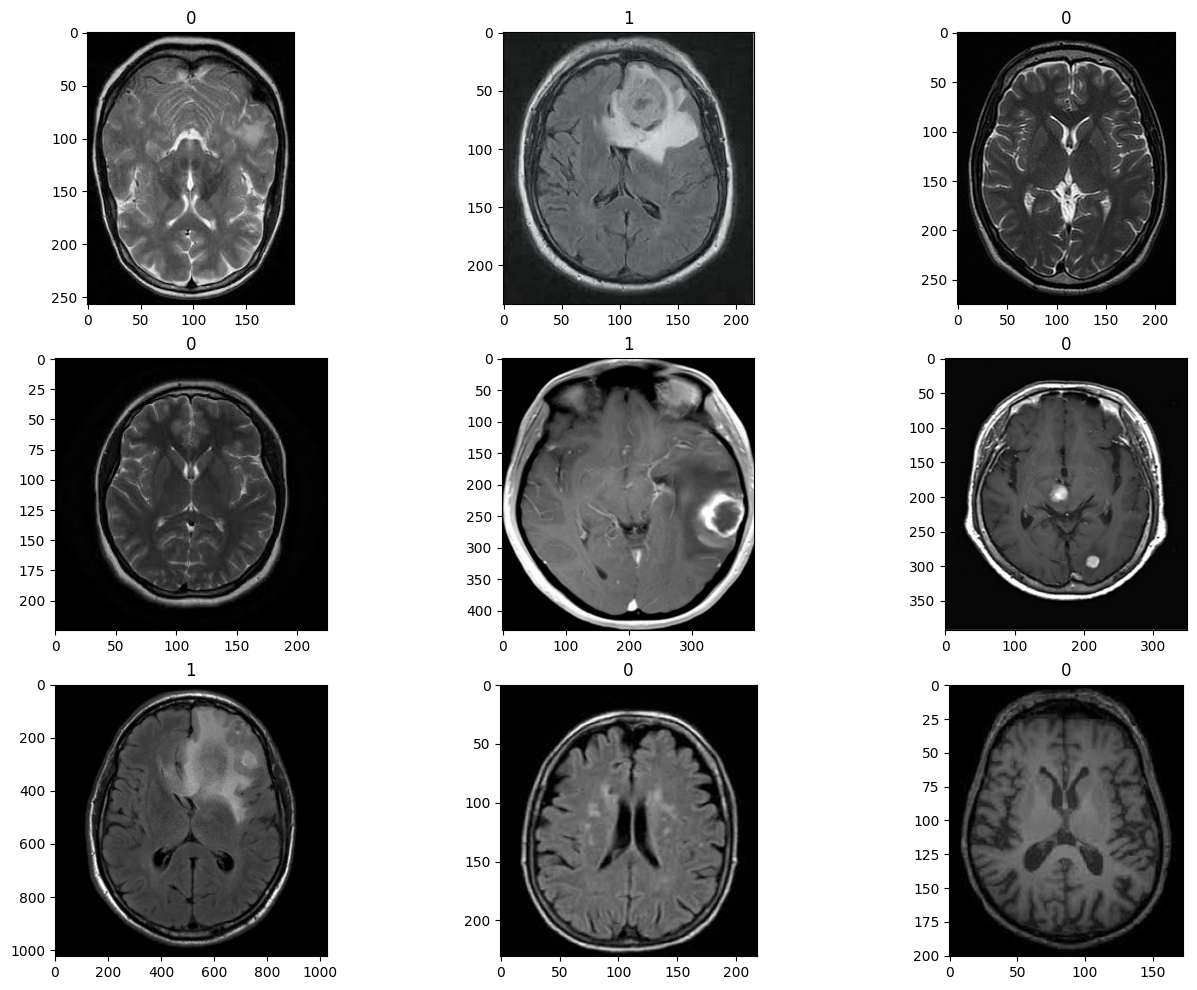

In [202]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [203]:
train_list, val_list = train_test_split(train_list,
                                        test_size=0.2,
                                        stratify=labels)

In [204]:
print("Train Data: ",len(train_list))
print("Validation Data: ",len(val_list))
print("Test Data: ",len(test_list))

Train Data:  108
Validation Data:  28
Test Data:  35


In [205]:
#Image Augmentation
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]
)

In [206]:
#Dataset
class MRIDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = (1 if (img_path.split('/')[-2].split('.')[0] == 'yes') else 0)
        label = torch.from_numpy(np.asarray(label))
        return img_transformed, label

In [207]:
# Create train, validation, and test datasets
train_dataset = MRIDataset(train_list, transform=train_transforms)
val_dataset = MRIDataset(val_list, transform=test_transforms)
test_dataset = MRIDataset(test_list, transform=test_transforms)


In [208]:
# create data loaders for the training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [209]:
#Line Transformer
efficient_transformer = Linformer(
    dim=128,
    seq_len = 49+1, #7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [210]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3
).to(device)

In [211]:
#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [214]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc/len(val_loader)
            epoch_val_loss += val_loss/len(val_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.9507 - acc: 0.4970 - val_loss : 0.8458 - val_acc: 0.4688



  0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.9325 - acc: 0.4643 - val_loss : 0.6832 - val_acc: 0.5833



  0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.9176 - acc: 0.5387 - val_loss : 1.2112 - val_acc: 0.4792



  0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.9070 - acc: 0.4673 - val_loss : 0.6997 - val_acc: 0.5208



  0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.7782 - acc: 0.5089 - val_loss : 0.7001 - val_acc: 0.5208

